In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def generate_tissue_mask(image_rgb, blur_kernel: int = 7) -> np.ndarray:
    """
    用灰階平均值作全域閾值，輸出 0/1 mask（tissue = 1）。

    Parameters
    ----------
    image_rgb   : ndarray (H, W, 3)  RGB 影像
    blur_kernel : int    Gaussian kernel 大小，必須是奇數

    Returns
    -------
    mask : ndarray (H, W)  uint8 (0 / 1)
    """
    gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
    gray_uint8 = cv2.normalize(gray, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    blur = cv2.GaussianBlur(gray_uint8, (blur_kernel, blur_kernel), 0)

    # --- 以平均值為閾值 ---
    thresh_val = blur.mean()
    mask = (blur < thresh_val).astype(np.uint8)   # 亮背景 → 0；較暗組織 → 1
    return mask

def extract_tile(image, x, y, tile_size=56):
    half = tile_size // 2
    x1, x2 = x - half, x + half
    y1, y2 = y - half, y + half
    if x1 < 0 or y1 < 0 or x2 > image.shape[1] or y2 > image.shape[0]:
        return np.zeros((tile_size, tile_size), dtype=np.uint8)
    return image[y1:y2, x1:x2]


def detect_invalid_spots_and_plot(image, x_coords, y_coords, 
                                   tile_size=56, title="Invalid Spot Detection", 
                                   return_invalid=True, ax=None):
    # Step 1: 建立 binary mask
    tissue_mask = generate_tissue_mask(image)

    # Step 2: 檢查每個 spot 是否 valid
    invalid_spots = []
    for i, (x, y) in enumerate(zip(x_coords, y_coords)):
        tile = extract_tile(tissue_mask, x, y, tile_size=tile_size)
        if tile.sum() == 0:
            invalid_spots.append((i, x, y))
    print(f"🚫 Found {len(invalid_spots)} invalid spots (outside tissue) in slide {title}")

    # Step 3: 畫圖（可支援傳入 ax 作為子圖）
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(image)
    ax.scatter(x_coords, y_coords, color='green', s=2, alpha=0.3, label='Valid Spots')
    if invalid_spots:
        invalid_x = [x for _, x, _ in invalid_spots]
        invalid_y = [y for _, _, y in invalid_spots]
        ax.scatter(invalid_x, invalid_y, color='red', s=8, alpha=0.8, label='Invalid Spots')
    ax.set_title(title)
    ax.axis('off')
    ax.legend()

    # Optional return
    if return_invalid:
        return invalid_spots

import os
os.chdir("/Users/deweywang/Desktop/GitHub/HEVisum/")

🚫 Found 1 invalid spots (outside tissue) in slide S_2
[(823, 324, 1701)]


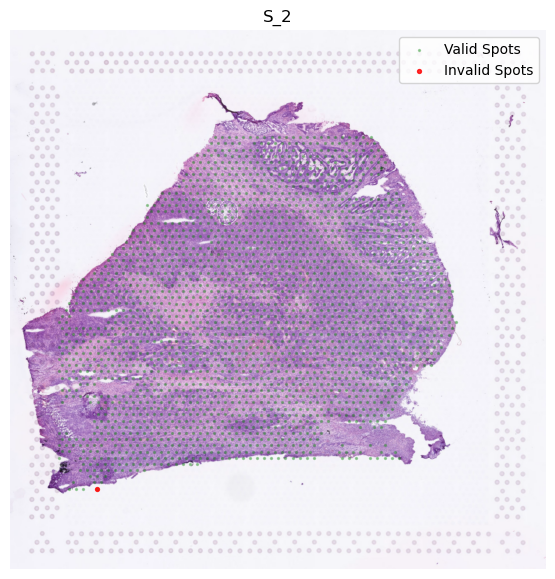

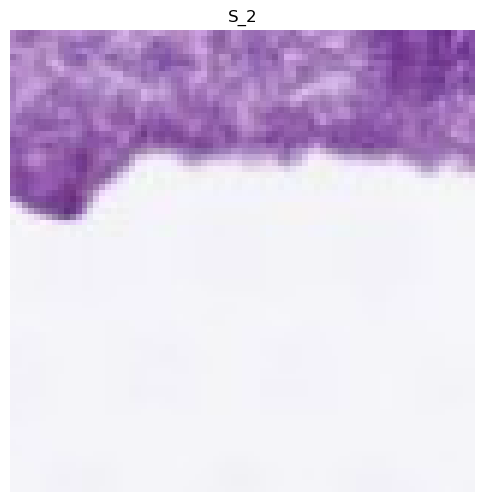

In [13]:

import h5py

with h5py.File("dataset/realign/original_data.h5", "r") as h5file:
    train_images = h5file["images/Train"]
    train_spots = h5file["spots/Train"]
    
    sample = 'S_2'
    image = np.array(train_images[sample])
    spots = np.array(train_spots[sample])
    x, y = spots["x"], spots["y"]
    print(detect_invalid_spots_and_plot(image, x, y, tile_size=26, title=sample))
    
    plt.figure(figsize=(6,6))
    plt.imshow(extract_tile(image, 324, 1701, tile_size=78), aspect="auto")
    #plt.scatter(x, y, color="red", s=1, alpha=0.4)
    plt.axis('off')
    plt.title(sample)
    plt.show()

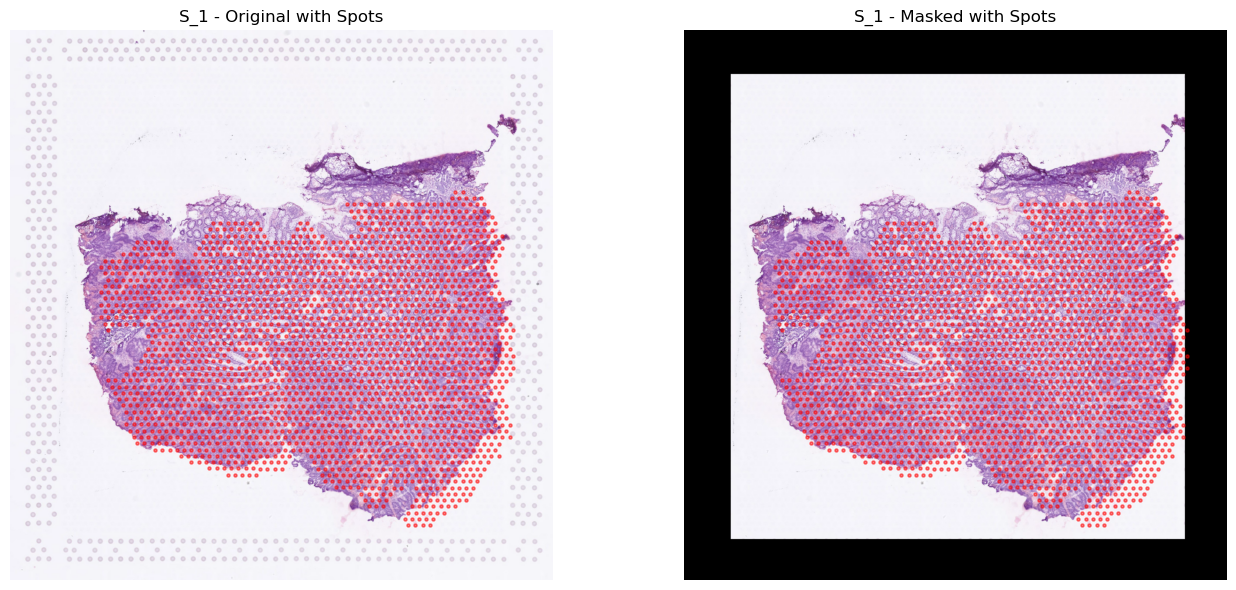

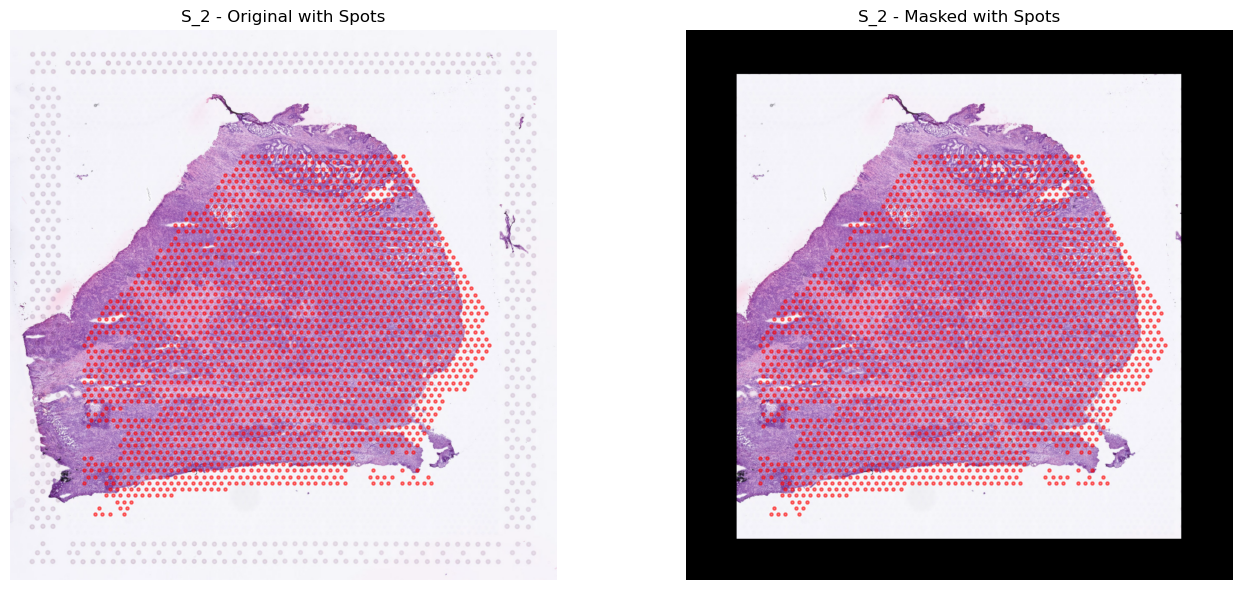

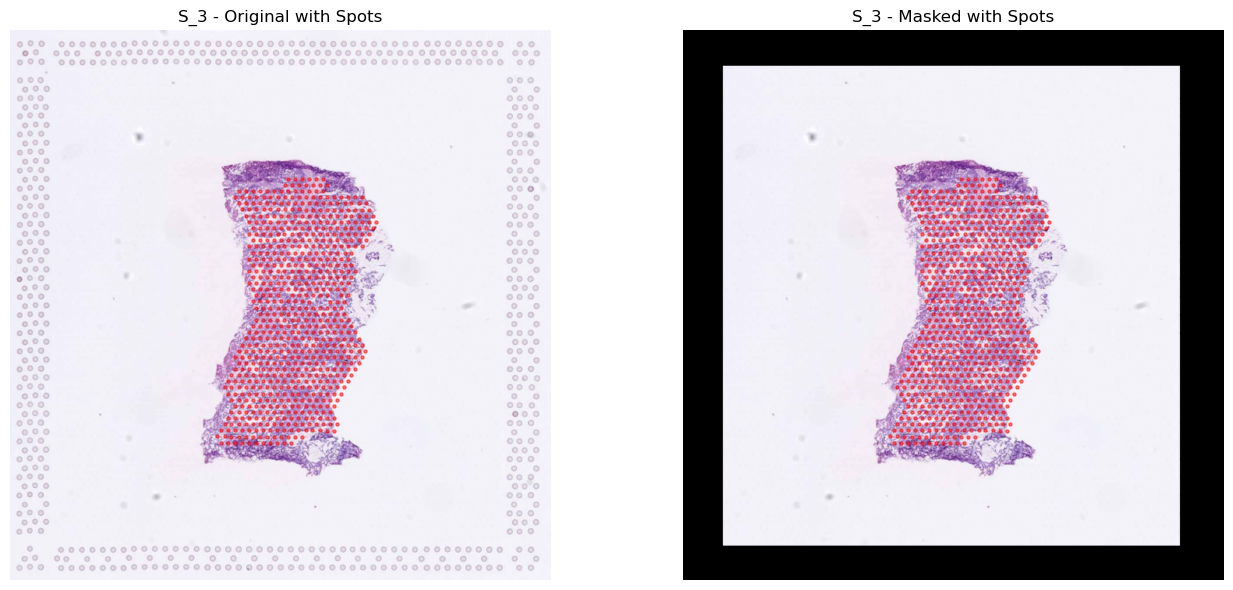

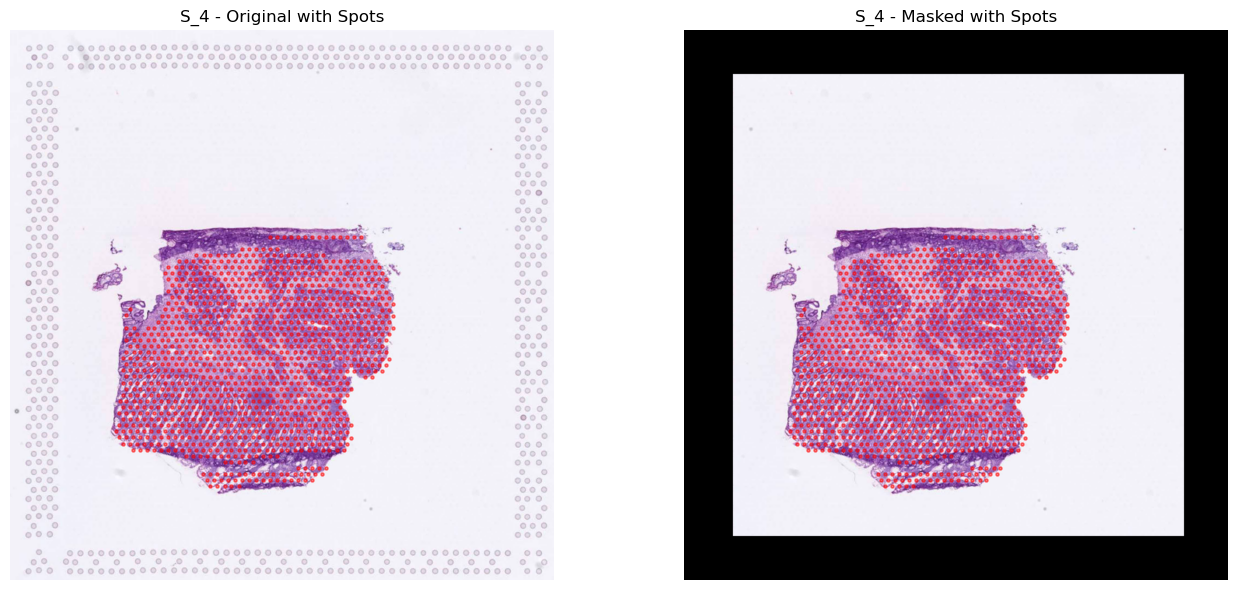

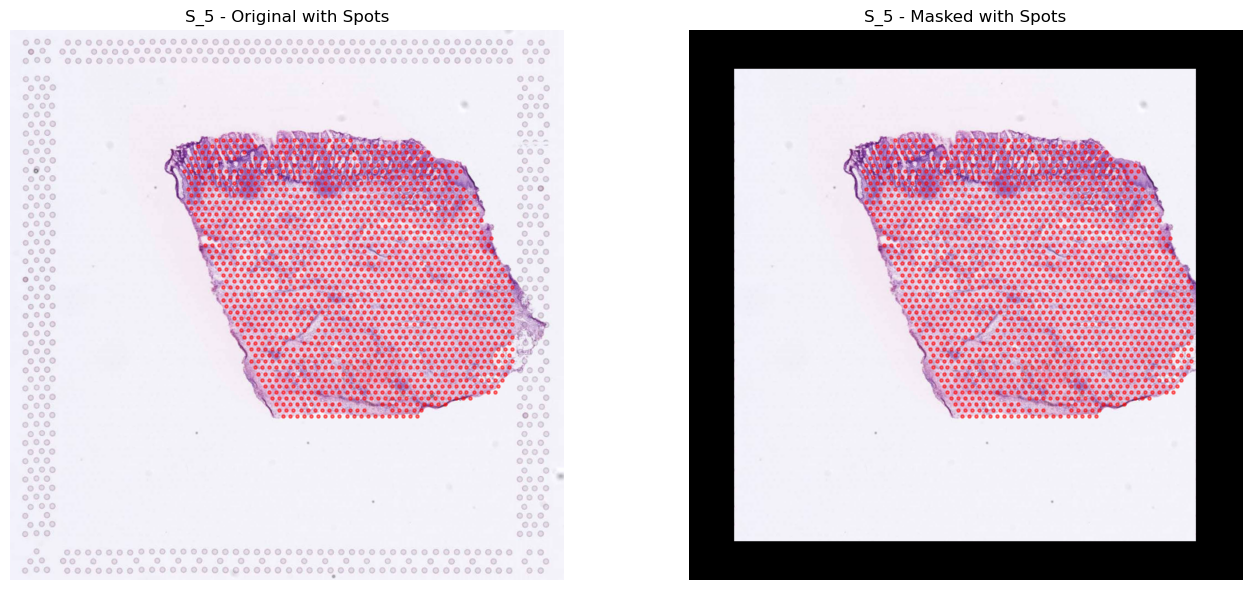

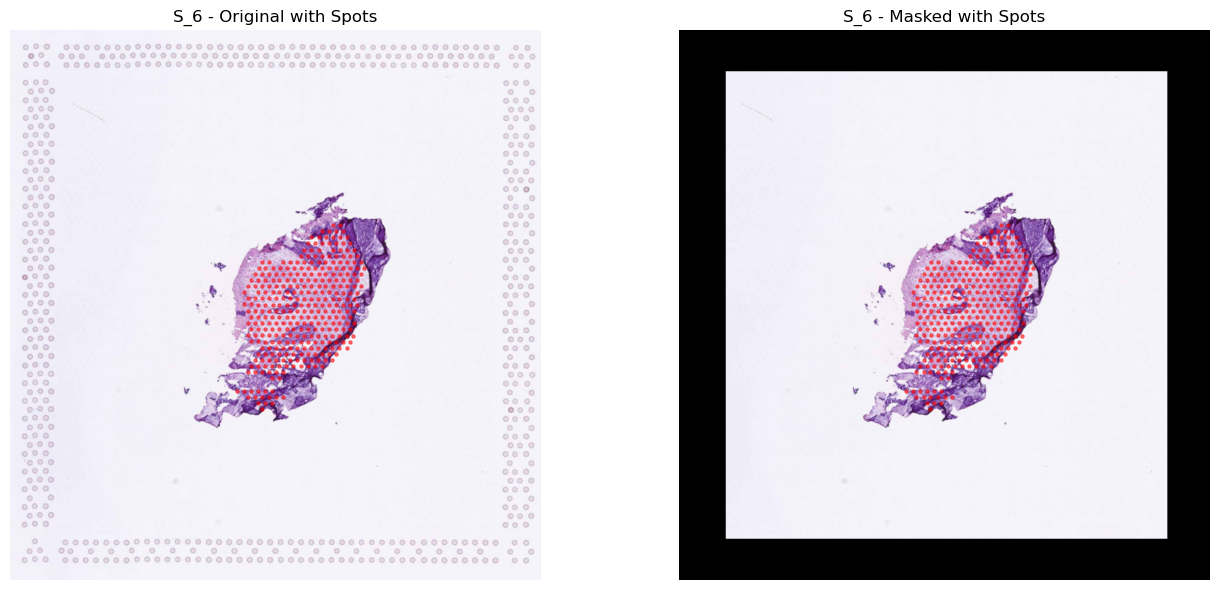

✅ 所有 masked 圖像已儲存到 './dataset/masked_images.h5'


In [6]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

def mask_image_edges_custom(image, margins, value=1):
    """
    將圖像四邊遮掉（不改變圖像大小），可個別設定上下左右邊距
    Args:
        image: numpy array (H, W, C)
        margins: tuple (top, bottom, left, right)
        value: 填充值（預設白色）
    """
    top, bottom, left, right = margins
    masked = image.copy()

    if len(image.shape) == 3:
        masked[:top, :, :] = value
        masked[-bottom:, :, :] = value
        masked[:, :left, :] = value
        masked[:, -right:, :] = value
    else:
        masked[:top, :] = value
        masked[-bottom:, :] = value
        masked[:, :left] = value
        masked[:, -right:] = value

    return masked

def plot_image_with_spots(image, masked_image, x_coords, y_coords, sample_id=""):
    """
    顯示原圖與 masked 圖像，並把 spot 座標疊加上去
    """
    plt.figure(figsize=(14, 6))

    # 原圖
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.scatter(x_coords, y_coords, s=5, c='red', alpha=0.5)
    plt.title(f"{sample_id} - Original with Spots")
    plt.axis("off")

    # 遮邊後的圖
    plt.subplot(1, 2, 2)
    plt.imshow(masked_image)
    plt.scatter(x_coords, y_coords, s=5, c='red', alpha=0.5)
    plt.title(f"{sample_id} - Masked with Spots")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# 假設這是你已經定義的 slide list
samples = ['S_1', 'S_2', 'S_3', 'S_4', 'S_5', 'S_6']
margin = 160
# 四邊 margin 設定：top, bottom, left, right（每張 slide 可不同）
slide_margins = {
    "S_1": (160, 149, 170, 153),
    "S_2": (160, 150, 184, 188),
    "S_3": (130, 125, 145, 160),
    "S_4": (160, 160, 178, 160),
    "S_5": (140, 140, 163, 170),
    "S_6": (150, 150, 170, 155),
}

# 建立新的 HDF5 檔案來存儲 masked images
with h5py.File("./dataset/masked_images.h5", "w") as out_h5:
    with h5py.File("./dataset/elucidata_ai_challenge_data.h5", "r") as h5file:
        for sample in samples:
            image = np.array(h5file["images/Train"][sample])
            spots = np.array(h5file["spots/Train"][sample])
            x_coords = spots["x"]
            y_coords = spots["y"]

            # 取得該 slide 專屬的四邊 margin
            margins = slide_margins.get(sample)

            # 遮邊
            masked_image = mask_image_edges_custom(image, margins=margins, value=0)

            # ✅ 存入 HDF5（用 sample 當 key）
            out_h5.create_dataset(name=f"images/{sample}", data=masked_image, compression="gzip")

            # ✅ 視覺化（如你需要）
            plot_image_with_spots(image, masked_image, x_coords, y_coords, sample_id=sample)

print("✅ 所有 masked 圖像已儲存到 './dataset/masked_images.h5'")



🚫 Found 0 invalid spots (outside tissue) in slide S_1 - RAW
🚫 Found 1 invalid spots (outside tissue) in slide S_2 - RAW
🚫 Found 0 invalid spots (outside tissue) in slide S_3 - RAW
🚫 Found 0 invalid spots (outside tissue) in slide S_4 - RAW
🚫 Found 0 invalid spots (outside tissue) in slide S_5 - RAW
🚫 Found 0 invalid spots (outside tissue) in slide S_6 - RAW


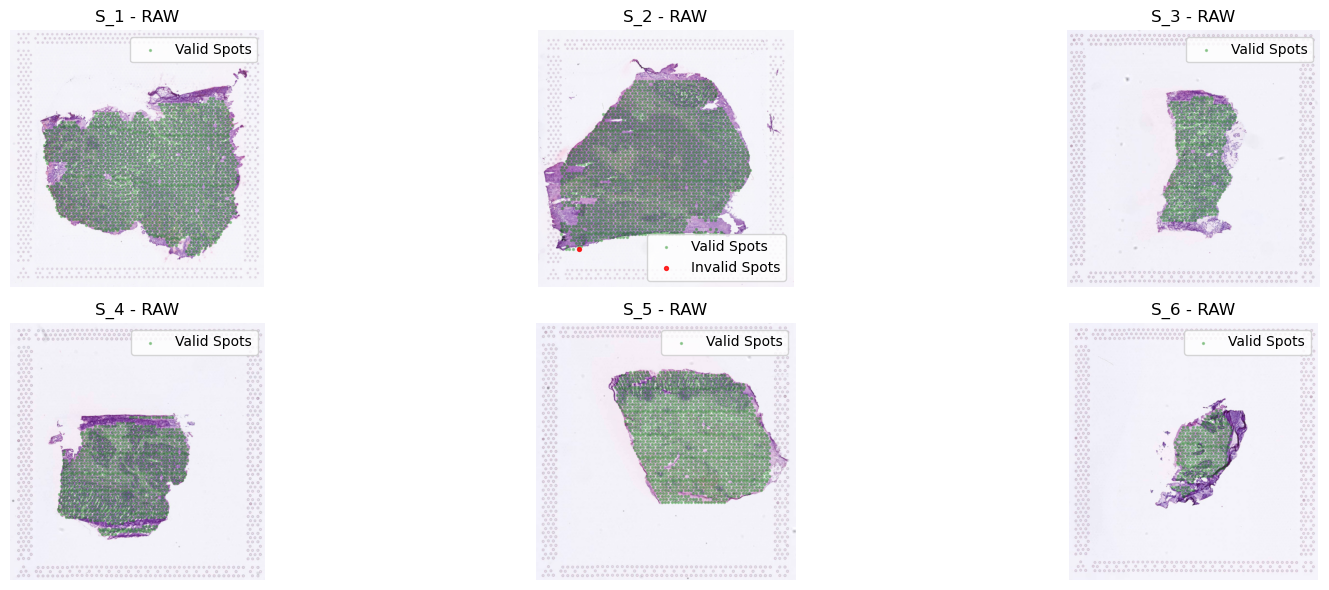

🚫 Found 633 invalid spots (outside tissue) in slide S_1 - MASKED
🚫 Found 766 invalid spots (outside tissue) in slide S_2 - MASKED
🚫 Found 6 invalid spots (outside tissue) in slide S_3 - MASKED
🚫 Found 48 invalid spots (outside tissue) in slide S_4 - MASKED
🚫 Found 941 invalid spots (outside tissue) in slide S_5 - MASKED
🚫 Found 57 invalid spots (outside tissue) in slide S_6 - MASKED


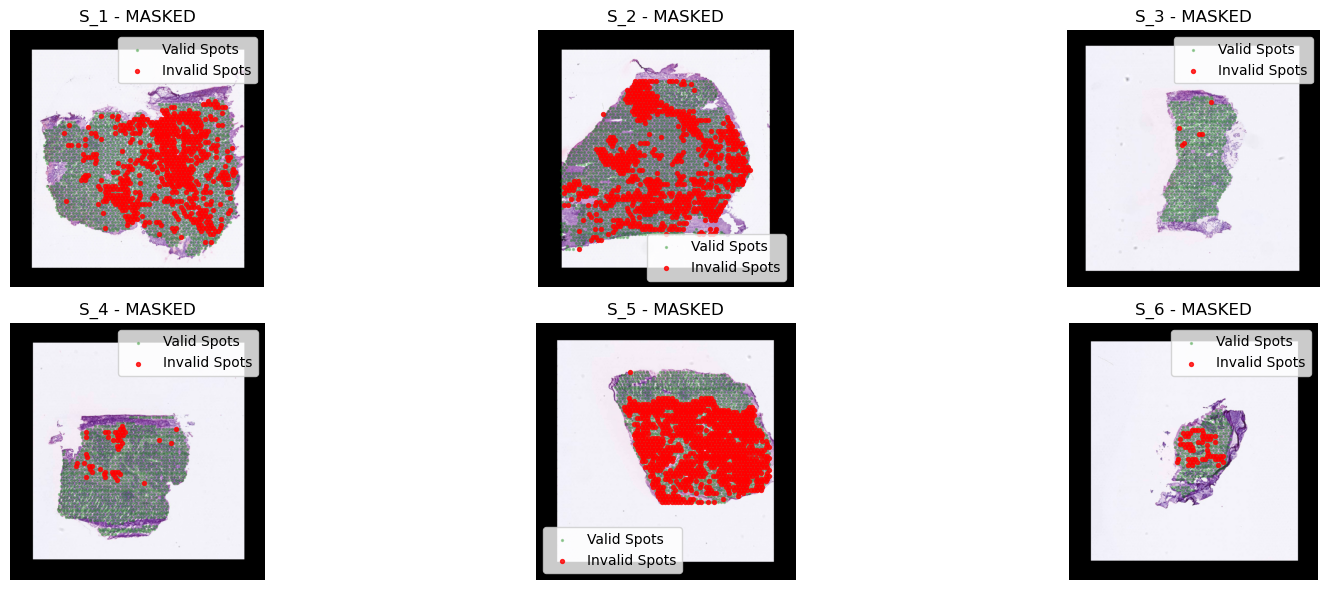

🔍 S_1: 633 differing invalid spots


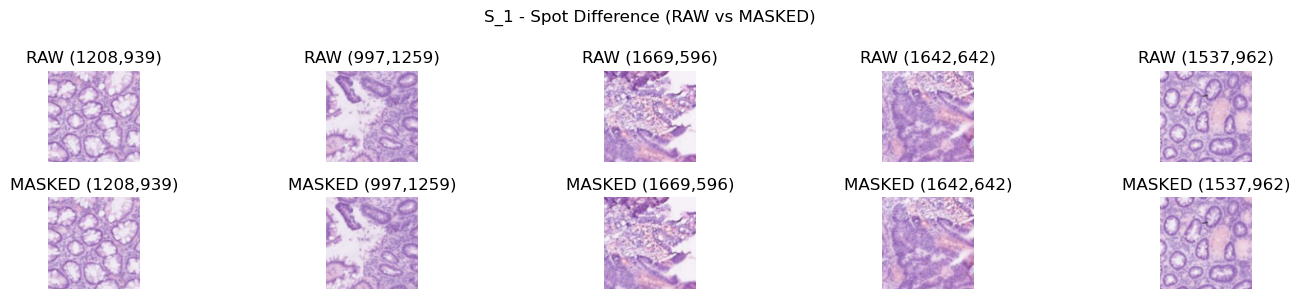

🔍 S_2: 765 differing invalid spots


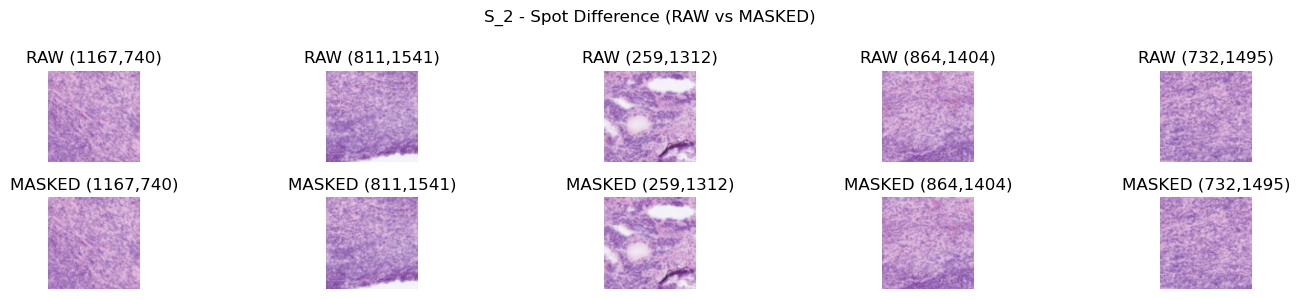

🔍 S_3: 6 differing invalid spots


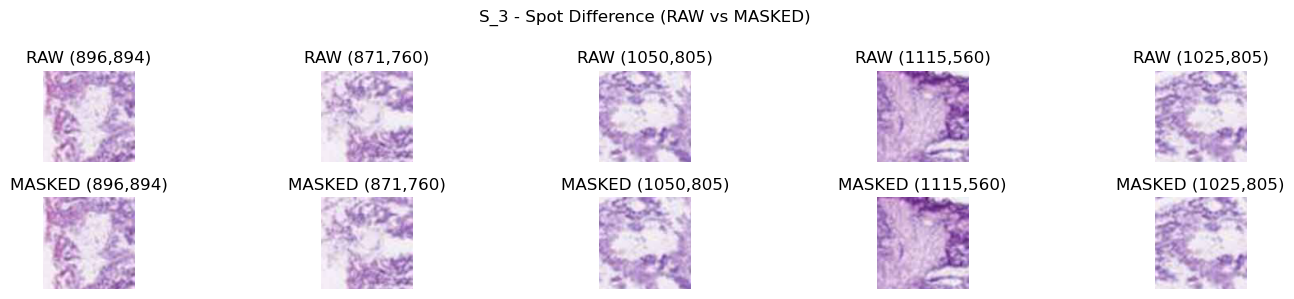

🔍 S_4: 48 differing invalid spots


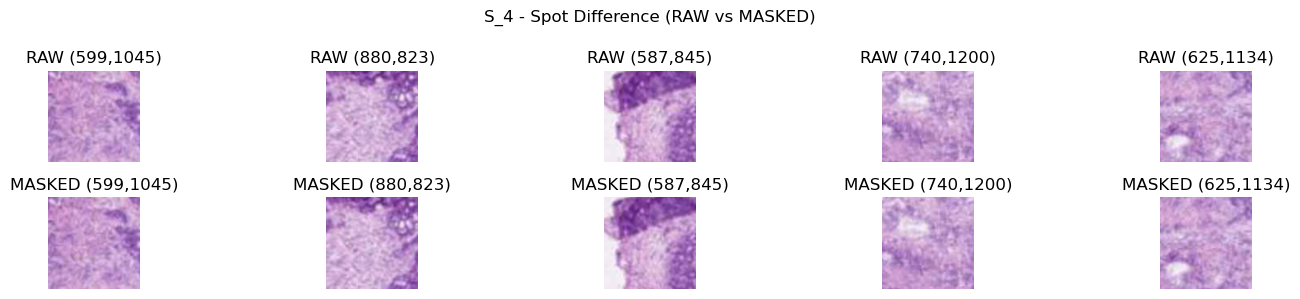

🔍 S_5: 941 differing invalid spots


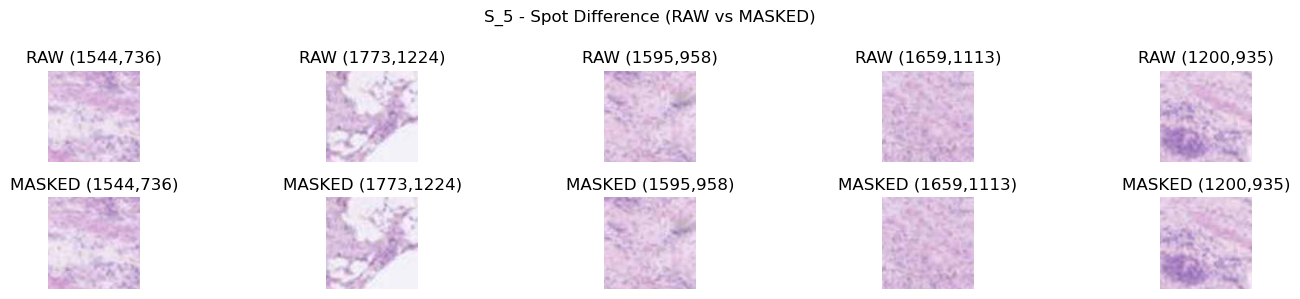

🔍 S_6: 57 differing invalid spots


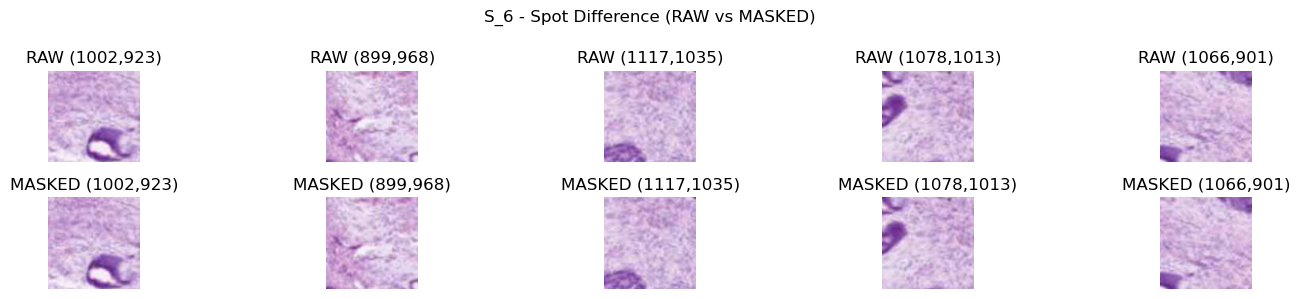

In [10]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

samples = ['S_1', 'S_2', 'S_3', 'S_4', 'S_5', 'S_6']
invalid_spots_raw = {}
invalid_spots_masked = {}

def extract_tile(image, x, y, tile_size=56):
    half = tile_size // 2
    x1, x2 = x - half, x + half
    y1, y2 = y - half, y + half
    return image[y1:y2, x1:x2]

def get_invalid_spot_coords(invalid_list):
    return set((x, y) for _, x, y in invalid_list)

# 1️⃣ 執行 raw image 判斷
with h5py.File("dataset/realign/original_data.h5", "r") as h5file:
    fig, axs = plt.subplots(2, 3, figsize=(18, 6))
    axs = axs.flatten()
    for i, sample in enumerate(samples):
        image = np.array(h5file["images/Train"][sample])
        spots = np.array(h5file["spots/Train"][sample])
        x_coords, y_coords = spots["x"], spots["y"]

        invalid = detect_invalid_spots_and_plot(image, x_coords, y_coords, ax=axs[i], title=f"{sample} - RAW", tile_size=26)
        invalid_spots_raw[sample] = invalid
    plt.tight_layout()
    plt.show()

# 2️⃣ 執行 masked image 判斷
with h5py.File("./dataset/masked_images.h5", "r") as masked_h5, \
     h5py.File("dataset/realign/original_data.h5", "r") as spot_h5:
    fig, axs = plt.subplots(2, 3, figsize=(18, 6))
    axs = axs.flatten()
    for i, sample in enumerate(samples):
        image = np.array(masked_h5[f"images/{sample}"])
        spots = np.array(spot_h5[f"spots/Train/{sample}"])
        x_coords, y_coords = spots["x"], spots["y"]

        invalid = detect_invalid_spots_and_plot(image, x_coords, y_coords, ax=axs[i], title=f"{sample} - MASKED", tile_size=26)
        invalid_spots_masked[sample] = invalid
    plt.tight_layout()
    plt.show()

# 3️⃣ 比對差異
diff_dict = {}
for sample in samples:
    raw_set = get_invalid_spot_coords(invalid_spots_raw.get(sample, []))
    masked_set = get_invalid_spot_coords(invalid_spots_masked.get(sample, []))
    diff = raw_set.symmetric_difference(masked_set)
    diff_dict[sample] = list(diff)

# 4️⃣ 裁圖 + 顯示
with h5py.File("dataset/realign/original_data.h5", "r") as raw_h5, \
     h5py.File("./dataset/masked_images.h5", "r") as masked_h5:
    for sample in samples:
        diff_points = diff_dict[sample]
        if not diff_points:
            print(f"✅ {sample}: No diff spots.")
            continue

        img_raw = np.array(raw_h5["images/Train"][sample])
        img_masked = np.array(masked_h5[f"images/{sample}"])

        print(f"🔍 {sample}: {len(diff_points)} differing invalid spots")

        plt.figure(figsize=(15, 3))
        for i, (x, y) in enumerate(diff_points[:5]):
            tile_raw = extract_tile(img_raw, x, y, tile_size=112)
            tile_masked = extract_tile(img_masked, x, y, tile_size=112)

            plt.subplot(2, 5, i + 1)
            plt.imshow(tile_raw)
            plt.title(f"RAW ({x},{y})")
            plt.axis("off")

            plt.subplot(2, 5, i + 6)
            plt.imshow(tile_masked)
            plt.title(f"MASKED ({x},{y})")
            plt.axis("off")

        plt.suptitle(f"{sample} - Spot Difference (RAW vs MASKED)")
        plt.tight_layout()
        plt.show()


In [6]:
raw_set

{(924, 1102), (937, 1079), (950, 1102), (963, 1079)}

🚫 Found 93 invalid spots


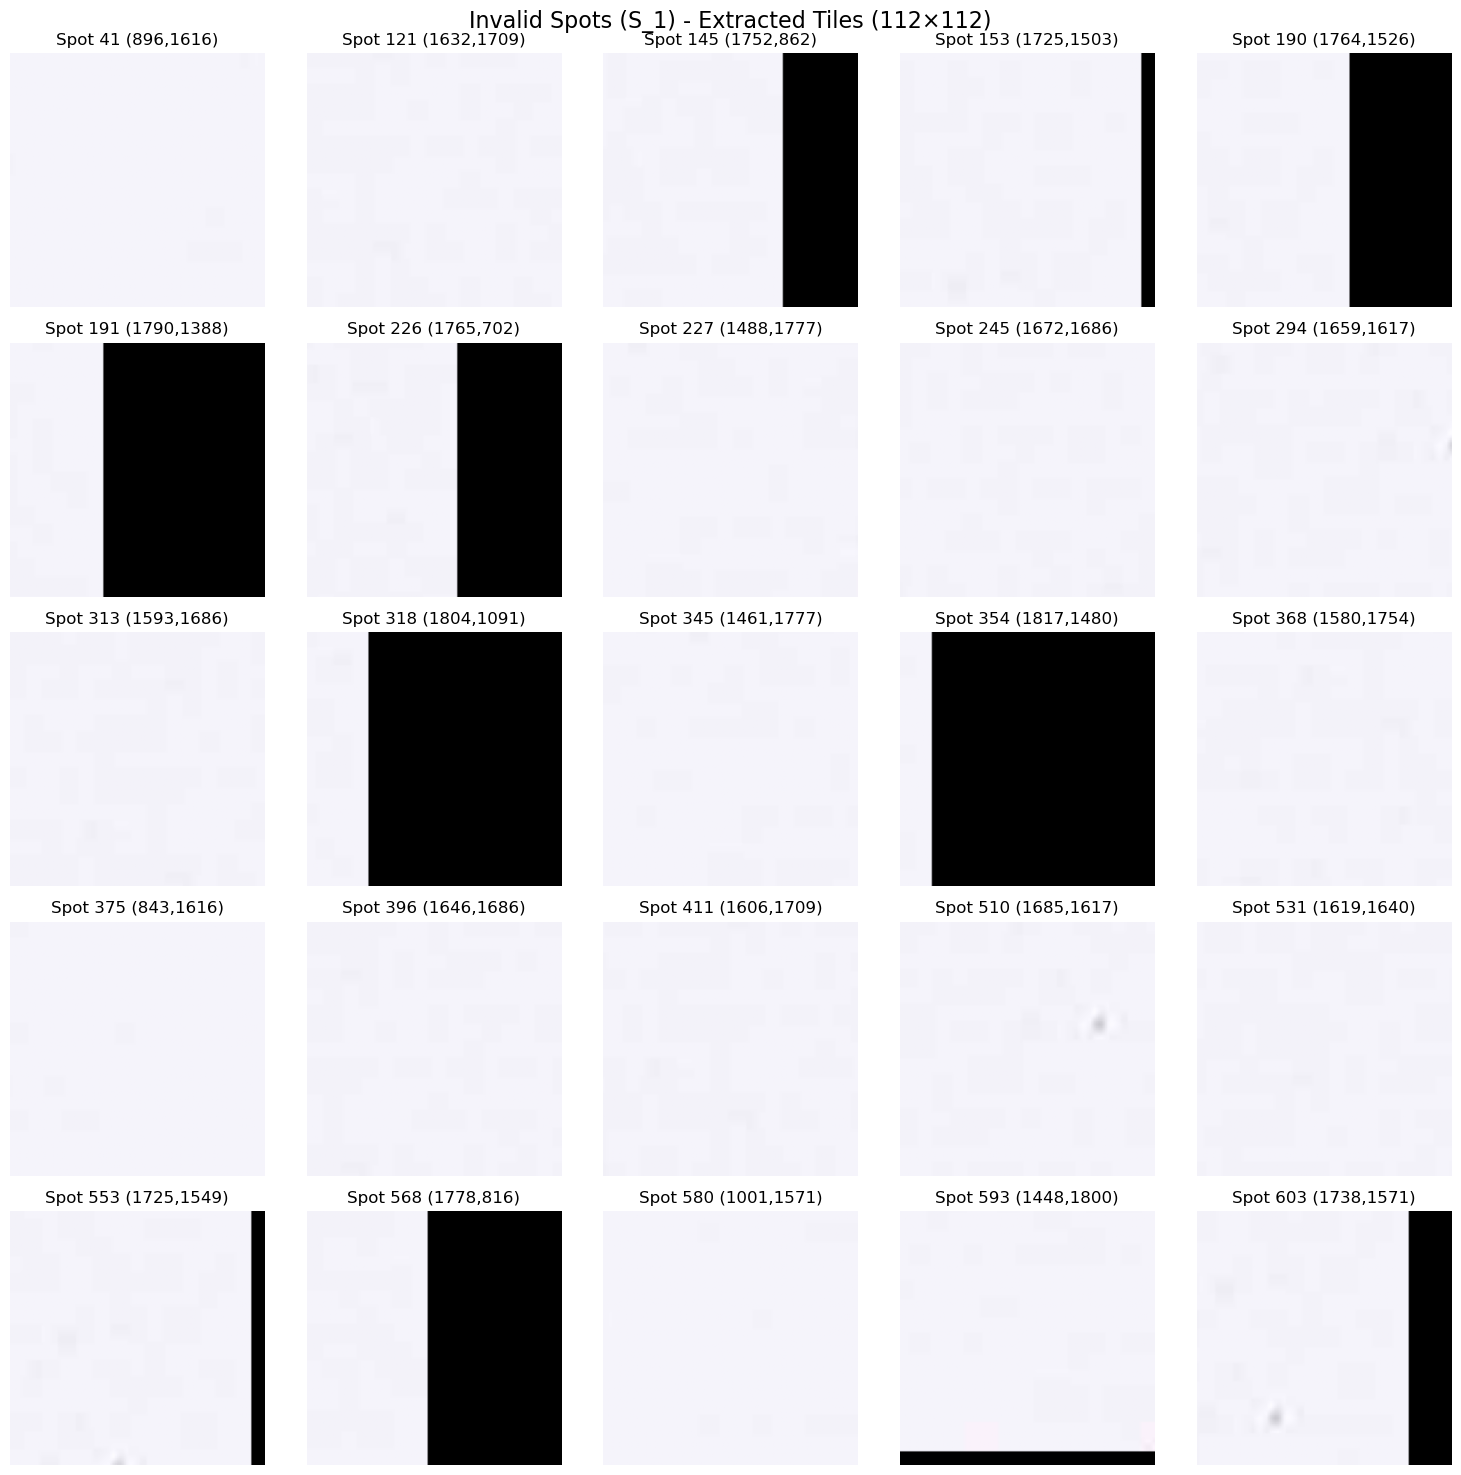

In [8]:
import matplotlib.pyplot as plt

# 1. 選定 slide 和 tile size
slide_id = 'S_1'
tile_size = 112

with h5py.File("./dataset/masked_images.h5", "r") as masked_h5, \
     h5py.File("./dataset/elucidata_ai_challenge_data.h5", "r") as spot_h5:
    
    # 🔁 用原始影像來建 mask
    original_image = np.array(spot_h5[f"images/Train/{slide_id}"])
    masked_image = np.array(masked_h5[f"images/{slide_id}"])
    
    spots = np.array(spot_h5[f"spots/Train/{slide_id}"])
    x_coords, y_coords = spots["x"], spots["y"]

# ✅ tissue mask 用原圖算
tissue_mask = generate_tissue_mask(original_image)

# 4. 找出 invalid spots
invalid_spots = []
for i, (x, y) in enumerate(zip(x_coords, y_coords)):
    mask_tile = extract_tile(tissue_mask, x, y, tile_size=26)
    if mask_tile.sum() == 0:
        invalid_spots.append((i, x, y))

print(f"🚫 Found {len(invalid_spots)} invalid spots")

num_show = min(25, len(invalid_spots))  # 最多顯示 25 張
cols = 5
rows = int(np.ceil(num_show / cols))

plt.figure(figsize=(cols * 3, rows * 3))
for idx in range(num_show):
    i, x, y = invalid_spots[idx]
    tile = extract_tile(image, x, y, tile_size=tile_size)

    ax = plt.subplot(rows, cols, idx + 1)
    ax.imshow(tile)
    ax.set_title(f"Spot {i} ({x},{y})")
    ax.axis('off')

plt.suptitle(f"Invalid Spots (S_1) - Extracted Tiles ({tile_size}×{tile_size})", fontsize=16)
plt.tight_layout()
plt.show()


🚫 Found 93 invalid spots (outside tissue) in slide S_1 - RAW
Valid points save: 2104, Raw point: 2197
🚫 Found 176 invalid spots (outside tissue) in slide S_2 - RAW
Valid points save: 2094, Raw point: 2270
🚫 Found 4 invalid spots (outside tissue) in slide S_3 - RAW
Valid points save: 686, Raw point: 690
🚫 Found 0 invalid spots (outside tissue) in slide S_4 - RAW
Valid points save: 1187, Raw point: 1187
🚫 Found 1 invalid spots (outside tissue) in slide S_5 - RAW
Valid points save: 1676, Raw point: 1677
🚫 Found 6 invalid spots (outside tissue) in slide S_6 - RAW
Valid points save: 322, Raw point: 328


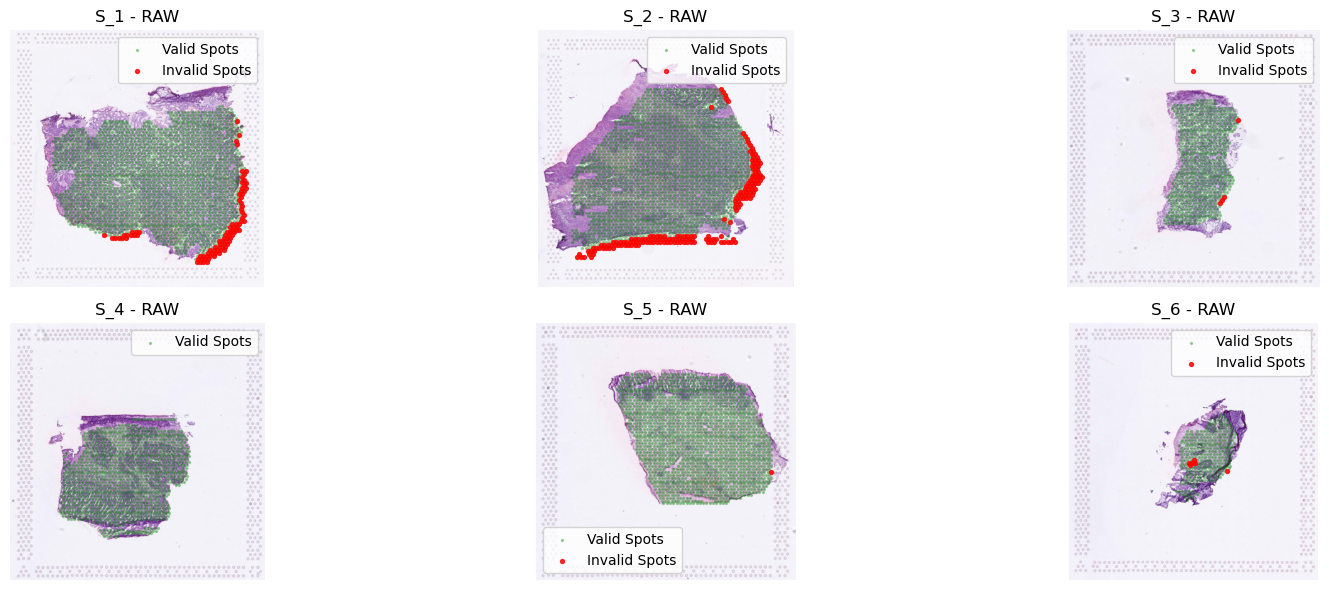

✅ 所有資料已儲存為 filteredd&masked_dataset.h5，結構與原始檔完全一致 ✅


In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

samples = ['S_1', 'S_2', 'S_3', 'S_4', 'S_5', 'S_6']
invalid_spots_raw = {}
valid_spots_dict = {}

# 1️⃣ 掃每張 slide，找出 invalid spots，並記下 valid_spots
with h5py.File("./dataset/realign/original_data.h5", "r") as h5file:
    fig, axs = plt.subplots(2, 3, figsize=(18, 6))
    axs = axs.flatten()

    for i, sample in enumerate(samples):
        image = np.array(h5file[f"images/Train/{sample}"])
        spots = np.array(h5file[f"spots/Train/{sample}"])
        x_coords, y_coords = spots["x"], spots["y"]

        invalid = detect_invalid_spots_and_plot(image, x_coords, y_coords, ax=axs[i], title=f"{sample} - RAW", tile_size=26)
        invalid_spots_raw[sample] = invalid

        valid_mask = np.ones(len(spots), dtype=bool)
        for idx, _, _ in invalid:
            valid_mask[idx] = False

        valid_spots = spots[valid_mask]
        print(f"Valid points save: {len(valid_spots)}, Raw point: {len(x_coords)}")
        valid_spots_dict[sample] = valid_spots

    plt.tight_layout()
    plt.show()

# 2️⃣ 儲存整個新資料集（完整格式）
with h5py.File("./dataset/filtered&masked_dataset.h5", "w") as out_h5, \
     h5py.File("./dataset/masked_images.h5", "r") as in_h5:

    # ✅ 建立完整資料結構
    grp_images = out_h5.create_group("images/Train")
    grp_spots = out_h5.create_group("spots/Train")

    for sample in samples:
        # 直接複製影像（原圖）
        image = in_h5[f"images/{sample}"]
        grp_images.create_dataset(sample, data=image, compression="gzip")

        # 存新的 spots（只保留 valid 的）
        valid_spots = valid_spots_dict[sample]
        grp_spots.create_dataset(sample, data=valid_spots, compression="gzip")

print("✅ 所有資料已儲存為 filteredd&masked_dataset.h5，結構與原始檔完全一致 ✅")


🚫 Found 0 invalid spots (outside tissue) in slide S_1 - RAW
Valid points save: 2197, Raw point: 2197
🚫 Found 1 invalid spots (outside tissue) in slide S_2 - RAW
Valid points save: 2269, Raw point: 2270
🚫 Found 0 invalid spots (outside tissue) in slide S_3 - RAW
Valid points save: 690, Raw point: 690
🚫 Found 0 invalid spots (outside tissue) in slide S_4 - RAW
Valid points save: 1187, Raw point: 1187
🚫 Found 0 invalid spots (outside tissue) in slide S_5 - RAW
Valid points save: 1677, Raw point: 1677
🚫 Found 0 invalid spots (outside tissue) in slide S_6 - RAW
Valid points save: 328, Raw point: 328


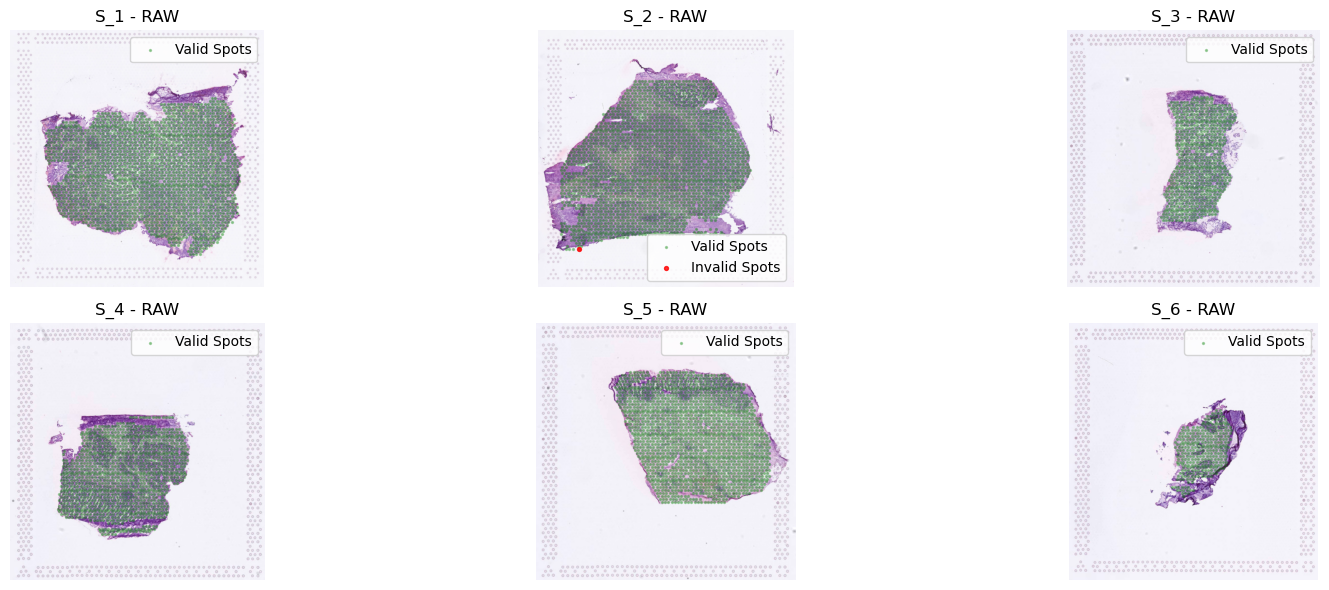

✅ 所有資料已儲存為 filteredd.h5，結構與原始檔完全一致 ✅


In [16]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

samples = ['S_1', 'S_2', 'S_3', 'S_4', 'S_5', 'S_6']
invalid_spots_raw = {}
valid_spots_dict = {}

# 1️⃣ 掃每張 slide，找出 invalid spots，並記下 valid_spots
with h5py.File("./dataset/realign/original_data.h5", "r") as h5file:
    fig, axs = plt.subplots(2, 3, figsize=(18, 6))
    axs = axs.flatten()

    for i, sample in enumerate(samples):
        image = np.array(h5file[f"images/Train/{sample}"])
        spots = np.array(h5file[f"spots/Train/{sample}"])
        x_coords, y_coords = spots["x"], spots["y"]

        invalid = detect_invalid_spots_and_plot(image, x_coords, y_coords, ax=axs[i], title=f"{sample} - RAW", tile_size=26)
        invalid_spots_raw[sample] = invalid

        valid_mask = np.ones(len(spots), dtype=bool)
        for idx, _, _ in invalid:
            valid_mask[idx] = False

        valid_spots = spots[valid_mask]
        print(f"Valid points save: {len(valid_spots)}, Raw point: {len(x_coords)}")
        valid_spots_dict[sample] = valid_spots

    plt.tight_layout()
    plt.show()

# 2️⃣ 儲存整個新資料集（完整格式）
with h5py.File("./dataset/realign/filtered_dataset.h5", "w") as out_h5, \
     h5py.File("./dataset/realign/original_data.h5", "r") as in_h5:

    # ✅ 建立完整資料結構
    grp_images = out_h5.create_group("images/Train")
    grp_spots = out_h5.create_group("spots/Train")

    for sample in samples:
        # 直接複製影像（原圖）
        image = in_h5[f"images/Train/{sample}"]
        grp_images.create_dataset(sample, data=image, compression="gzip")

        # 存新的 spots（只保留 valid 的）
        valid_spots = valid_spots_dict[sample]
        grp_spots.create_dataset(sample, data=valid_spots, compression="gzip")

print("✅ 所有資料已儲存為 filteredd.h5，結構與原始檔完全一致 ✅")


In [ ]:

    
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as patches
# ====== 載入資料：只做 S_1 ======
sample = 'S_7'

with h5py.File("./dataset/elucidata_ai_challenge_data.h5", "r") as h5file:
    image = (h5file["images/Test"])
    spots = (h5file["spots/Test"])
    image = np.array(image[sample])
    spots = np.array(spots[sample])
    x, y = spots["x"], spots["y"]

invalid_spots = detect_invalid_spots_and_plot(image, x, y, tile_size=56, title=sample)
plt.tight_layout()
plt.show()

<HDF5 dataset "S_7": shape (2088,), type "|V24">


<Figure size 640x480 with 0 Axes>